In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
CUDA = True
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
weight_path = './yolov3.weights'
coco_path = './coco.names'

## Download weight file, around 300mb

In [3]:
import urllib.request
if not osp.exists(weight_path):
    urllib.request.urlretrieve('https://pjreddie.com/media/files/yolov3.weights', weight_path)  

In [4]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [5]:
classes = load_coco(coco_path)

# Preprocess Image

In [6]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

In [7]:
def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
        
    return image, (box_w, box_h, box_x, box_y, ratio)

In [8]:
# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, trans

# Basic network building blocks - conv_bn_relu, res_layer

In [9]:
class conv_bn_relu(nn.Module):
    def __init__(self, nin, nout, ks, s=1, pad='SAME', padding=0, bn=True, act="leakyRelu"):
        super().__init__()
        
        self.bn = bn
        self.act = act
                
        if pad == 'SAME':
            padding = (ks - 1) // 2
            
        self.conv = nn.Conv2d(nin, nout, ks, s, padding, bias=not bn)
        if bn == True:
            self.bn = nn.BatchNorm2d(nout)
        if act == "leakyRelu":
            self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class res_layer(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv1 = conv_bn_relu(nin, nin//2, ks=1)
        self.conv2 = conv_bn_relu(nin//2, nin, ks=3)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

# Map2cfgDict - used  to creating mapping that follows the cfg file from prjreddit's repository

In [10]:
def map2cfgDict(mlist):
    idx = 0
    mdict = OrderedDict()
    for i,m in enumerate(mlist):
        if isinstance(m, res_layer):
            mdict[idx] = None
            mdict[idx+1] = None
            idx += 2
        mdict[idx] = i
        idx += 1
    return mdict

# Darknet53 - Feature extraction

In [11]:
def make_res_stack(nin, num_blk):
    return nn.ModuleList([conv_bn_relu(nin, nin*2, 3, s=2)] \
           + [res_layer(nin*2) for n in range(num_blk)])

class Darknet(nn.Module):
    def __init__(self, blkList, nout=32):
        super().__init__()
        self.mlist = nn.ModuleList()
        self.mlist += [conv_bn_relu(3, nout, 3)]
        for i,nb in enumerate(blkList):
            self.mlist += make_res_stack(nout*(2**i), nb)
            
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        self.cachedOutDict[idxs] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        return self.cachedOutDict[idxs]

# PreDetectionConvGroup - conv layers before the yolo detection layer

In [12]:
class PreDetectionConvGroup(nn.Module):
    def __init__(self, nin, nout, num_conv=3):
        super().__init__()
        self.mlist = nn.ModuleList()
        
        for i in range(num_conv):
            self.mlist += [conv_bn_relu(nin, nout, ks=1)]
            self.mlist += [conv_bn_relu(nout, nout*2, ks=3)]
            if i == 0:
                nin = nout*2
                
        self.mlist += [nn.Conv2d(nin, 255, 1)]
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist 
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        
        self.cachedOutDict[idx] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        return self.cachedOutDict[idx]
    
    def getIdxFromYoloIdx(self,idx):
        if idx < 0:
            return len(self.map2yolocfg) + idx
        else:
            return self.map2yolocfg[idx]

# UpsampleGroup - grab feature maps from early high resolution layers and concatenate it with upsampled feature maps

In [13]:
class UpsampleGroup(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv = conv_bn_relu(nin, nin//2, ks=1)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, route_head, route_tail):
        out = self.up(self.conv(route_head))
        return torch.cat((out, route_tail), 1)

# Yolo Detection Layer

In [14]:
class YoloLayer(nn.Module):
    def __init__(self, anchors, numClass):
        super().__init__()
        self.anchors = torch.Tensor(anchors).to(device)
        self.numClass = numClass
        
        #self.mlist = nn.ModuleList()
        #self.det = [conv_bn_relu(3, 4, 3)]
        #self.mlist += self.det
        
    def forward(self, x, img_dim):
        grid_size = x.shape[-1]
        numBBoxAttrib = 5 + self.numClass
        numAnchors = len(self.anchors)
        stride = img_dim // grid_size
        
        #Reshape the feature map from [batch x channel x grid_w x grid_h] to [batch x boundingbox x box attributes]
        x = x.permute(0,2,3,1).contiguous().view(-1, grid_size*grid_size*numAnchors, numBBoxAttrib)
        
        #Sigmoid tx,ty,to
        x[:,:,:2] = x[:,:,:2].sigmoid()
        x[:,:,4] = x[:,:,4].sigmoid()
        
        #Add cx,cy to sig(tx),sig(ty) , create cx,cy creating meshgrid of "grid_size"
        x_offset = torch.arange(grid_size).view(1,-1,1,1).repeat(grid_size,1,numAnchors,1).view(grid_size*grid_size*numAnchors, 1)
        y_offset = torch.arange(grid_size).view(-1,1,1,1).repeat(1,grid_size,numAnchors,1).view(grid_size*grid_size*numAnchors, 1)
        mesh = torch.cat((x_offset,y_offset), 1)
        x[:,:,:2] = x[:,:,:2].add(mesh.to(device))
        
        #Rescale anchors to fit the stride, multiply it by e^(tw) and e^(th)
        x[:,:,2:4] = torch.exp(x[:,:,2:4]).mul(self.anchors.div(stride).repeat(grid_size**2,1))
        
        #Sigmoid class scores
        x[:,:,5:] = x[:,:,5:].sigmoid()
        
        #Rescale bx,by,bw,bh by stride to orginal image size
        x[:,:,:4] *= stride
                
        return x

# Entire network - putting everything together

In [15]:
class YoloNet(nn.Module):
    def __init__(self, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]):
        super().__init__()
        nin = 32
        numClass = 80
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512)
        self.yolo1 = YoloLayer(anchors[0], numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256)
        self.yolo2 = YoloLayer(anchors[1], numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128)
        self.yolo3 = YoloLayer(anchors[2], numClass)
        
    def forward(self,x):
        #Get image dimension
        img_size = x.shape[-1]
        
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, img_size)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, img_size)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, img_size)
        
        return det1,det2,det3
    
    def loadWeight(self, weights_path):
        wm = WeightManager(self)
        wm.loadWeight(weights_path)

# WeightManager - load weight file from official Yolo site

In [16]:
class WeightManager:
    def __init__(self, model):
        super().__init__()
        self.conv_list = self.find_conv_layers(model)

    def loadWeight(self, weight_path):
        ptr = 0
        weights = self.read_file(weight_path)
        print(len(weights))
        for m in self.conv_list:
            if type(m) == conv_bn_relu:
                ptr = self.load_conv_bn_relu(m, weights, ptr)
            elif type(m) == nn.Conv2d:
                ptr = self.load_conv2D(m, weights, ptr)
        return ptr
                
    def read_file(self, file):
        with open(file, "rb") as fp:
            header = np.fromfile(fp, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3]
            weights = np.fromfile(fp, dtype = np.float32)
        return weights
    
    def copy_weight_to_model_parameters(self, param, weights, ptr):
        num_el = param.numel()
        param.data.copy_(torch.from_numpy(weights[ptr:ptr + num_el])
                             .view_as(param.data))
        return ptr + num_el
    
    def load_conv_bn_relu(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bn.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.weight, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_mean, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_var, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.conv.weight, weights, ptr)
        return ptr
        
    def load_conv2D(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.weight, weights, ptr)
        return ptr
        
    def find_conv_layers(self, mod):
        module_list = []
        for m in mod.children():
            if type(m) == conv_bn_relu:
                module_list += [m]
            elif type(m) == nn.Conv2d:
                module_list += [m]
            elif isinstance(m, (nn.ModuleList, nn.Module)):
                module_list += self.find_conv_layers(m)
            elif type(m) == res_layer:
                module_list += self.find_conv_layers(m)
        return module_list

In [ ]:
net = YoloNet().to(device).eval()
net.loadWeight(weight_path)

In [ ]:
imglist = os.listdir('imgs')
for i,img in enumerate(imglist):
    print('{}: {}'.format(i,img))

In [ ]:
img_path = f"imgs/{imglist[0]}"
resolution = 416
testData, trans = load_image(img_path, mode='letterbox', dim=(resolution, resolution))
testData = testData.unsqueeze(0).to(device)
det1,det2,det3 = net(testData)

det1.shape,det2.shape,det3.shape

# Helper functions to find unique values in tensor

In [18]:
def torch_unique(inp, CUDA=True):
    if CUDA:
        inp_cpu = inp.detach().cpu()
    
    res_cpu = torch.unique(inp_cpu)
    res = inp.new(res_cpu.shape)
    res.copy_(res_cpu)
    
    return res

In [21]:
def unqiue_with_order(inp, CUDA=True):
    if CUDA:
        inp_np = inp.detach().cpu().numpy()
    
    _, idx = np.unique(inp, return_index=True)
    result = inp_np[np.sort(idx)]
    result_tensor = torch.from_numpy(result)
    res = inp.new(result_tensor.shape)
    res.copy_(result_tensor)
    return res


# IOU and non-max supression(NMS)

In [22]:
def iou_vectorized(bbox):
    num_box = bbox.shape[0]
    
    bbox_leftTop_x =  bbox[:,0]
    bbox_leftTop_y =  bbox[:,1]
    bbox_rightBottom_x = bbox[:,2]
    bbox_rightBottom_y = bbox[:,3]
    
    inter_leftTop_x     =  torch.max(bbox_leftTop_x.unsqueeze(1).repeat(1,num_box), bbox_leftTop_x)
    inter_leftTop_y     =  torch.max(bbox_leftTop_y.unsqueeze(1).repeat(1,num_box), bbox_leftTop_y)
    inter_rightBottom_x =  torch.min(bbox_rightBottom_x.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_x)
    inter_rightBottom_y =  torch.min(bbox_rightBottom_y.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_y)
    
    inter_area = torch.clamp(inter_rightBottom_x - inter_leftTop_x, min=0) * torch.clamp(inter_rightBottom_y - inter_leftTop_y, min=0)
    bbox_area = (bbox_rightBottom_x - bbox_leftTop_x) * (bbox_rightBottom_y - bbox_leftTop_y)
    union_area = bbox_area.expand(num_box,-1) + bbox_area.expand(num_box,-1).transpose(0, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

#Iterate through the bounding boxes and remove rows accordingly
def reduce_row_by_column(inp):
    i = 0
    while i < inp.shape[0]:
        remove_row_idx = inp[i][1].item()
        if inp[i][0] != remove_row_idx and i < inp.shape[0]:
            keep_mask = (inp[:,0] != remove_row_idx).nonzero().squeeze()
            inp = inp[keep_mask]
        i += 1
    return inp

#bbox is expected to be sorted by class score in descending order
def nms(bbox, iou, nms_thres):
    #Create a mapping that indicates which row has iou > threshold
    remove_map = (iou > nms_thres).nonzero()
    remove_map = reduce_row_by_column(remove_map)
    
    remove_idx = torch_unique(remove_map[:,0])
    res_bbox = bbox[remove_idx]
    
    return res_bbox

# Post-processing - convert predictions from network to bounding boxes (calls IOU/NMS)

In [23]:
def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    results = torch.Tensor().to(device)
    
    for b in range(num_batches):
        batch_results = torch.Tensor().to(device)
        img_det = detections[b]
        
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
        
        if img_det.shape[0] != 0:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            num_dets = batch_results.shape[0]
            batch_col = results.new_full((num_dets, 1), b)
            batch_results = torch.cat((batch_col, batch_results), 1)
            results = torch.cat((results, batch_results), 0)
    
    return results

In [24]:
detections = torch.cat((det1,det2,det3), 1)
pdet = postprocessing(detections, 80, obj_conf_thr=0.5)
detections.shape, pdet.shape

(torch.Size([1, 10647, 85]), torch.Size([3, 8]))

In [25]:
print(pdet.shape)
pdet

torch.Size([3, 8])


tensor([[   0.0000,   69.5402,  173.2032,  170.3746,  343.0714,    0.9997,
            0.9885,   16.0000],
        [   0.0000,   89.2842,  110.7768,  303.7395,  294.2656,    0.9952,
            0.9997,    1.0000],
        [   0.0000,  256.4959,   98.3481,  373.2535,  144.1314,    0.9953,
            0.9430,    7.0000]], device='cuda:0')

# Draw image and predictions

In [26]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [27]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [28]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)

In [29]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [30]:
def bbox_plt(box):
    bx, by = box[0], box[1]
    bw = box[2] - box[0]
    bh = box[3] - box[1]
    return [bx, by, bw, bh]

In [31]:
def show_output(img, dets):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        draw_rect(ax, bbox_plt(d))
        c = classes[d[-1].int().item()]
        draw_text(ax, d[:2], c)

## Show predictions with the image processed by the network (letterboxed image)

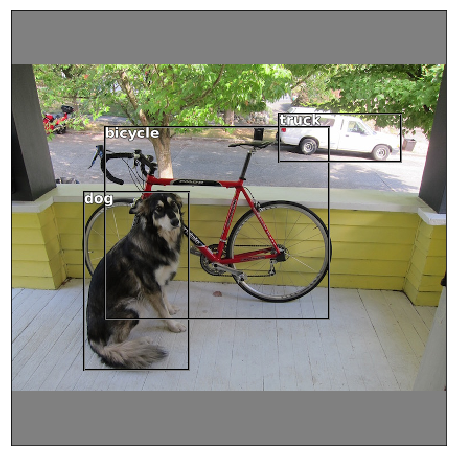

In [32]:
show_output(testData.squeeze(0).permute(1,2,0), pdet[:,1:])

## Transform bounding boxes to fit the original image's dimension

In [33]:
#load the original image with no letterbox
img, _ = load_image(f"imgs/{imglist[0]}")
img = img.permute(1,2,0)

In [34]:
def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[:,[0,2]] = torch.clamp((box[:,[0,2]] - x_offset) / ratio, 0, x_max)
    box[:,[1,3]] = torch.clamp((box[:,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

In [35]:
#trans is returned from the load_image call when we first input the letterboxed image into the network
box = pdet[:, 1:5]
box = bbox_transform(box, img.shape[1], img.shape[0], *trans[-3:])
box

tensor([[ 128.3819,  223.7597,  314.5377,  537.3625],
        [ 164.8324,  108.5111,  560.7498,  447.2596],
        [ 473.5309,   85.5657,  689.0833,  170.0887]], device='cuda:0')

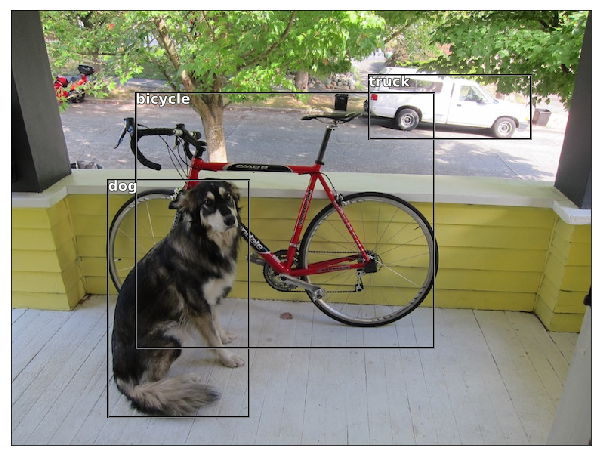

In [36]:
show_output(img, pdet[:,1:])

# Run through the dataset

In [37]:
class YoloDataset(Dataset):
    # Mode - None, 'letterbox', 'resize'
    def __init__(self, data_dir, resize_dim, mode=None):
        self.data_dir = data_dir
        self.resize_dim = resize_dim
        self.mode = mode
        self.data_files_list = [f for f in os.listdir(f'{self.data_dir}') if os.path.isfile(os.path.join(f'{self.data_dir}', f))]
        self.trans_dict = dict()
        
    def __len__(self):
        return len(self.data_files_list)
    
    def __getitem__(self, idx):
        image_path = os.path.join(f'{self.data_dir}', self.data_files_list[idx])
        image, trans = load_image(image_path, mode=self.mode, dim=self.resize_dim)
        if self.mode == 'letterbox':
            self.trans_dict[idx] = trans
        return image
    
    @property
    def filenames(self):
        return self.data_files_list
    

In [38]:
bs = 4
img_folder = f"imgs/"
resize_dim = (416, 416)

yolo_ds = YoloDataset(img_folder, resize_dim, mode='letterbox')
yolo_dl = DataLoader(yolo_ds, batch_size=bs, shuffle=False, num_workers=0)

In [39]:
def predict(net, dataloader):
    with torch.no_grad():
        res = Tensor().to(device)
        running_len = 0
        for inp in dataloader:
            inp = inp.to(device)

            det1,det2,det3 = net(inp)
            dets = torch.cat((det1,det2,det3), 1)
            post_dets = postprocessing(dets, 80, obj_conf_thr=0.5)

            post_dets[:,0] = post_dets[:,0] + running_len
            res = torch.cat((res, post_dets), 0)
            running_len += inp.shape[0]

        return res

In [40]:
net = YoloNet().to(device).eval()
net.loadWeight(weight_path)

62001757


In [41]:
res = predict(net, yolo_dl)
print(res.shape)

torch.Size([155, 8])


In [42]:
yolo_ds.mode = None

In [43]:
def show_output_from_ds(ds, dets, idx):
    img = ds[idx].permute(1,2,0)
    trans = ds.trans_dict[idx]
    row_dets = (dets[:,0] == idx).nonzero().squeeze()
    img_dets = dets[row_dets, 1:].view(-1,7).clone()
    
    if img_dets.shape[0] != 0:
        box = img_dets[:,:4]
        box = bbox_transform(box, img.shape[1], img.shape[0], *trans[-3:])
    
    show_output(img, img_dets)

## Change the last argument to see different images placed under /img folder

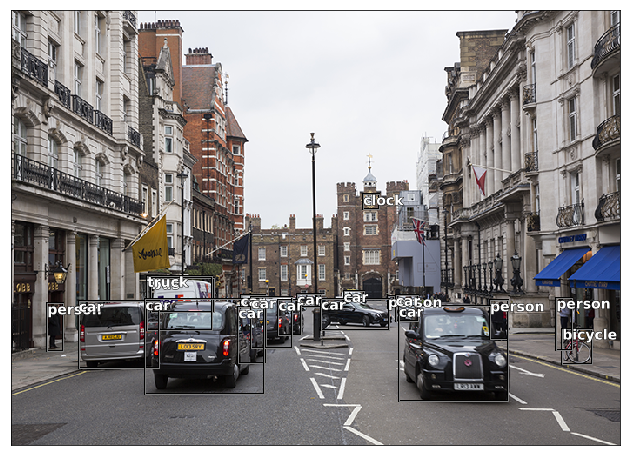

In [44]:
show_output_from_ds(yolo_ds, res, 9)

In [45]:
imglist = os.listdir('imgs')
for i,img in enumerate(imglist):
    print('{}: {}'.format(i,img))

0: dog.jpg
1: scream.jpg
2: img3.jpg
3: eddy.jpeg
4: eagle.jpg
5: person.jpg
6: ny_street.jpeg
7: hk_traffic_1.jpeg
8: 034_Felice_Herrig_vs_Cortney_Casey.0.jpg
9: london.png
10: nick.jpeg
11: cup1.jpg
12: hk_traffic.jpeg
13: edwin.jpeg
14: two_asian.jpeg
15: giraffe.jpg
16: img4.jpg
17: exvsmbon.jpg
18: img1.jpg
19: img2.jpg
20: dog-cycle-car.png
21: messi.jpg
22: herd_of_horses.jpg
